In [1]:
import json
import pandas as pd
import community.community_louvain
import networkx as nx
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


## Azure Bulk Downloads

In [74]:

# Load the data
logs_df = pd.read_csv("./FileDownloadedX.csv")

# Filter the logs
filtered_logs = logs_df[logs_df['event.action'] == 'FileDownloaded']

# Group em by user
grouped_logs = filtered_logs.groupby('user.id')

# Aggregate
aggregated_logs = grouped_logs.agg(num_downloads=('event.action', 'count'),
                                   total_downloads=('event.action', lambda x: (x == 'FileDownloaded').sum()),
                                   first_location=('client.ip', 'min'),
                                   last_location=('client.ip', 'max'))

# Apply filter on aggregated data
stats = aggregated_logs[(aggregated_logs['num_downloads'] > 5) & (aggregated_logs['total_downloads'] > 100)]

stats

,num_downloads,total_downloads,first_location,last_location
user.id,,,,
app@sharepoint,13504,13504,15.17.18.19,15.17.18.19
guest#hello.ip@gmail.com,8304,8304,140.150.60.70,140.150.60.70


In [75]:
df = pd.read_csv("./FileDownloads.csv")
df.shape, df.columns

((360528, 18),
 Index(['client.ip', 'event.action', 'event.type', 'file.directory',
        'file.extension', 'file.name', 'network.type',
        'o365.audit.AppAccessContext.ClientAppName',
        'o365.audit.ApplicationDisplayName', 'o365.audit.BrowserName',
        'o365.audit.FileSizeBytes', 'o365.audit.IsManagedDevice',
        'o365.audit.Platform', 'url.original', 'user.domain', 'user.id',
        'user.name', 'o365.audit.UserAgent'],
       dtype='object'))

In [41]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv("./FileDownloads.csv")

# Relevant feature selection
selected_columns = ['user.id', 'file.name', 'client.ip', 'o365.audit.UserAgent', 'o365.audit.FileSizeBytes']

df_ipv4 = df[df['client.ip'].apply(lambda x: ':' not in x)]

df_unique_combinations = df_ipv4.drop_duplicates(subset=['user.id', 'file.name', 'client.ip'])
selected_data = df_unique_combinations[selected_columns]

# Preprocessing
ip_addresses = selected_data['client.ip']
ip_integers = [int(ip.replace('.', '')) for ip in ip_addresses]

# One-hot encoding for categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(selected_data[['user.id', 'file.name', 'o365.audit.UserAgent']])

numerical_features = selected_data[['o365.audit.FileSizeBytes']].values
encoded_features = np.concatenate((encoded_data, np.array(ip_integers).reshape(-1, 1), numerical_features), axis=1)

# Train Model
model = GaussianMixture(n_components=2, covariance_type='full')
model.fit(encoded_features)

# Predict anomalies
anomaly_scores = model.score_samples(encoded_features)
threshold = np.percentile(anomaly_scores, 95)  # Adjust percentile based on desired anomaly rate
anomalies_indices = np.where(anomaly_scores < threshold)[0]
anomalies = df_unique_combinations.iloc[anomalies_indices]
anomalies[['user.id', 'file.name', 'o365.audit.UserAgent']]

,user.id,file.name,o365.audit.UserAgent
0,urn:spo:guest#kI.iyer@milkywayasia.hk,20240526_Order Summary_milkyway China.xlsx,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
1,kim.matsuda@milkyway.com,Pulp Digest Monthly - 2024 - 4.pdf,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
114,kim.matsuda@milkyway.com,Current Call List.pdf,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
122,bckampulpops@milkyway.com,Current Call List.pdf,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
124,nicholas.charlesdarwin@milkyway.com,Affiche personne de garde.xlsx,TeamsMobile-iOS
...,...,...,...
322420,irene.palmer@milkyway.com,Q&A Dev Journey Recording-20240517_083512-Meet...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
324003,melanie.rocks@milkyway.com,Myworkspace_profile_TRIS L._v1.docx,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
324004,melanie.rocks@milkyway.com,Myspace_profile_HOLLY P._v1.docx,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
325588,melanie.rocks@milkyway.com,Myworkspace_profile_PATRICK E._v1.docx,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


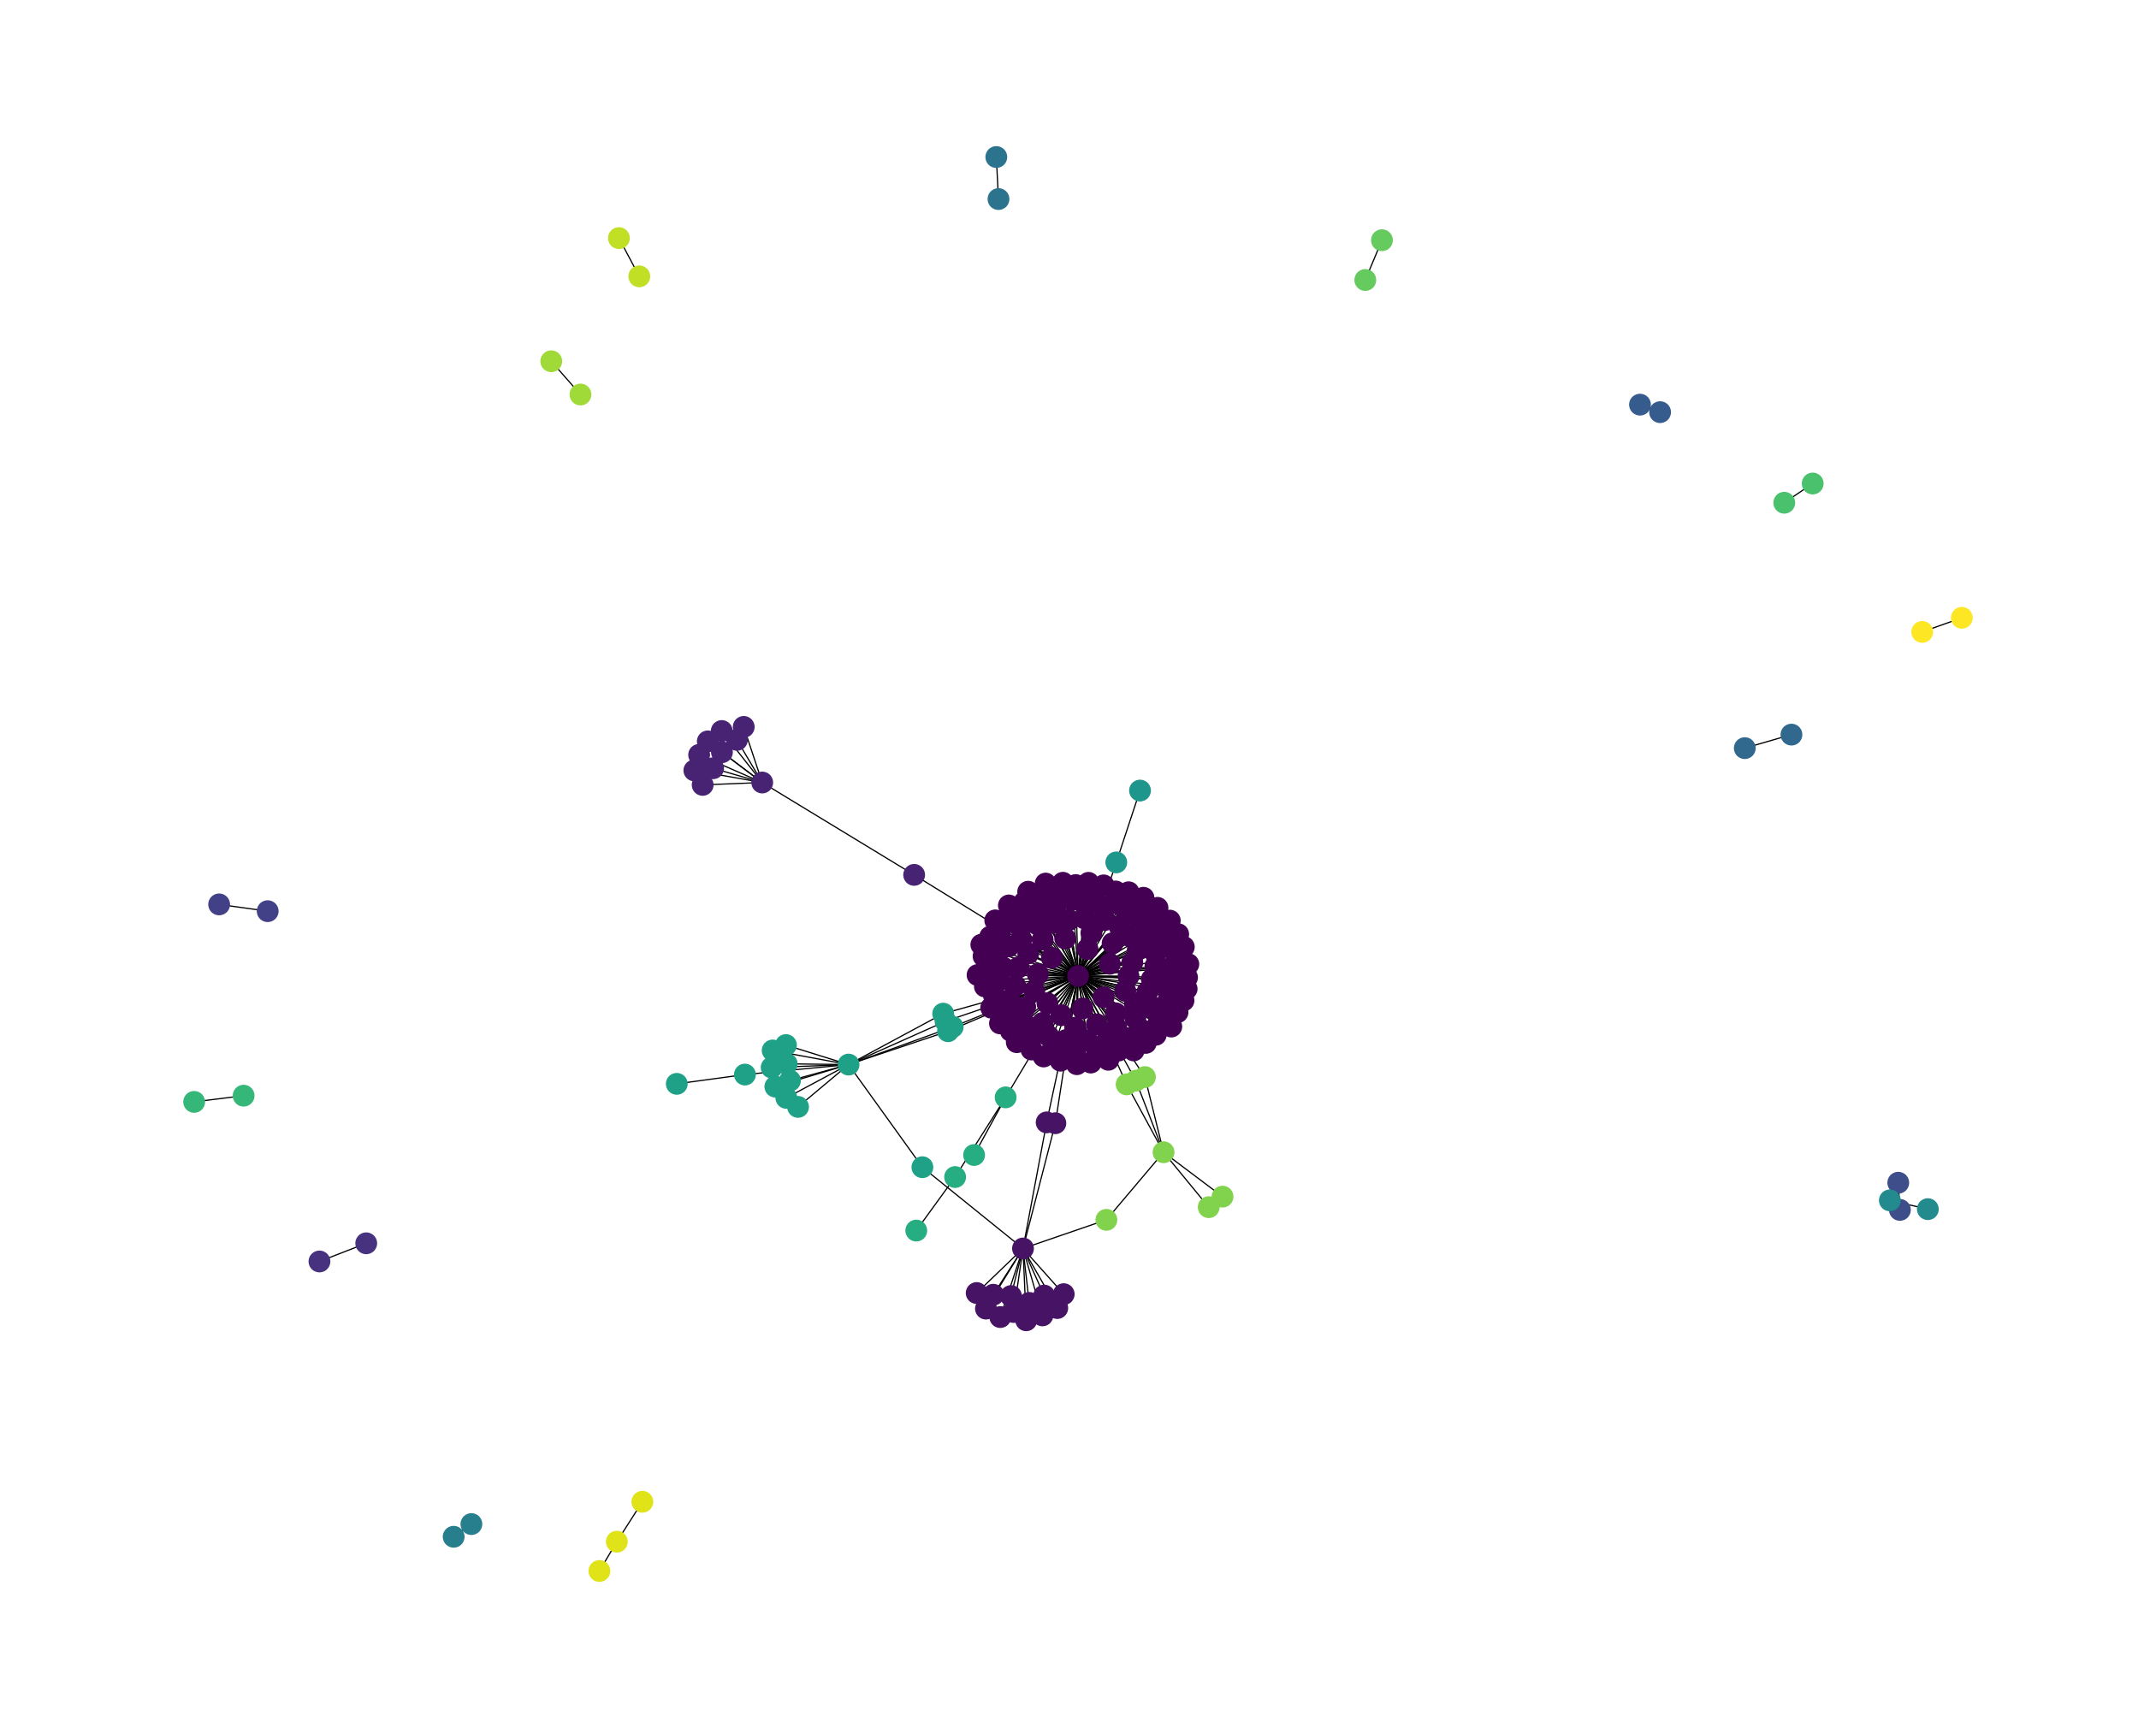

In [42]:
G = nx.Graph()
G = nx.from_pandas_edgelist(anomalies, 'user.id','o365.audit.UserAgent')

part = community.community_louvain.best_partition(G)
values = [part.get(node) for node in G.nodes()]

figure(figsize=(25, 20))
nx.draw_spring(G, node_color=values,with_labels=False)

In [44]:
df.shape, anomalies.shape

((360528, 18), (507, 18))

In [47]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder

# Relevant feature selection
selected_columns = ['user.id', 'file.name', 'client.ip', 'o365.audit.UserAgent', 'o365.audit.FileSizeBytes']

df_ipv4 = df[df['client.ip'].apply(lambda x: ':' not in x)]

df_unique_combinations = df_ipv4.drop_duplicates(subset=['user.id', 'file.name', 'client.ip'])
selected_data = df_unique_combinations[selected_columns]

# Preprocessing
ip_addresses = selected_data['client.ip']
ip_integers = [int(ip.replace('.', '')) for ip in ip_addresses]

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(selected_data[['user.id', 'file.name', 'o365.audit.UserAgent']])

numerical_features = selected_data[['o365.audit.FileSizeBytes']].values
encoded_features = np.concatenate((encoded_data, np.array(ip_integers).reshape(-1, 1), numerical_features), axis=1)

# Train Model
model = GaussianMixture(n_components=2, covariance_type='full')
model.fit(encoded_features)

anomaly_scores = model.score_samples(encoded_features)
threshold = np.percentile(anomaly_scores, 5)
anomalies_indices = np.where(anomaly_scores < threshold)[0]
anomalies = selected_data.iloc[anomalies_indices, :]

final_anomalies = anomalies[selected_columns]
final_anomalies.shape

(27, 5)

In [70]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

df = pd.read_csv("./FileDownloads.csv")
selected_columns = ['user.id', 'file.name', 'client.ip', 'o365.audit.Platform', 'o365.audit.FileSizeBytes']

df_ipv4 = df[df['client.ip'].apply(lambda x: ':' not in x)]

df_unique_combinations = df_ipv4.drop_duplicates(subset=['user.id', 'file.name', 'client.ip'])

selected_data = df_unique_combinations[selected_columns]

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_categorical = encoder.fit_transform(selected_data[['user.id', 'file.name', 'o365.audit.Platform']])

scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(selected_data[['o365.audit.FileSizeBytes']])

processed_data = np.concatenate((encoded_categorical, scaled_numerical), axis=1)

X_train, X_test = train_test_split(processed_data, test_size=0.2, random_state=42)

# Define and train the autoencoder model
input_dim = processed_data.shape[1]
encoding_dim = 3  # Adjust as needed
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder_layer = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
decoder_layer = tf.keras.layers.Dense(input_dim, activation='relu')(encoder_layer)
autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoder_layer)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

# Use the trained autoencoder to reconstruct data
reconstructed_data = autoencoder.predict(processed_data)
reconstruction_errors = np.mean(np.square(processed_data - reconstructed_data), axis=1)

threshold = np.percentile(reconstruction_errors, 95)

anomalies = df_unique_combinations[reconstruction_errors > threshold]
print("Anomaly Count: ", anomalies.shape)
anomalies[['user.id', 'client.ip', 'o365.audit.Platform', 'o365.audit.FileSizeBytes']].head()

Epoch 1/50
14/14 [==============================] - 1s 15ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 2/50
14/14 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 3/50
14/14 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 4/50
14/14 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 5/50
14/14 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 6/50
14/14 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 7/50
14/14 [==============================] - 0s 8ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 8/50
14/14 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 9/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 10/50
14/14 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 11/50
14/14

,user.id,client.ip,o365.audit.Platform,o365.audit.FileSizeBytes
124,nicholas.charlesdarwin@milkyway.com,96.20.106.36,NotSpecified,32549
5399,royce.corbin@milkyway.com,15.17.18.20,NotSpecified,205303
7705,vincent.roy@milkyway.com,24.54.61.98,NotSpecified,11301
7764,jocelyn.kathy@milkyway.com,15.17.18.20,iPad,60096
7824,jocelyn.kathy@milkyway.com,15.17.18.20,iPad,60096


## Suspicious File Access

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

df = pd.read_csv('FileAccessX.csv')

original_df = df.copy()

df = df[['user.id', 'client.ip', 'o365.audit.ApplicationDisplayName', 'o365.audit.AuthenticationType']]

# Handling missing values
df.fillna(method='ffill', inplace=True)

# Encoding categorical features
label_encoders = {}
for column in df.columns:
    if df[column].dtype == 'object':
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

# Scaling numerical features
scaler = StandardScaler()
df[['client.ip']] = scaler.fit_transform(df[['client.ip']])

X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
X_train = X_train.values
X_test = X_test.values

# Building the autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 3
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compiling & Training
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

predictions = autoencoder.predict(X_test)

# Calculating reconstruction error
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
threshold = np.mean(mse) + 2 * np.std(mse)

anomaly_indices = np.where(mse > threshold)[0]
anomalies = original_df.iloc[anomaly_indices]

anomalies.reset_index(drop=True, inplace=True)
anomalies[['file.extension', 'o365.audit.ApplicationDisplayName', 'o365.audit.AuthenticationType', 'count']]

Epoch 1/50
730/730 [==============================] - 2s 2ms/step - loss: 19828.4922 - val_loss: 208.0337
Epoch 2/50
730/730 [==============================] - 2s 3ms/step - loss: 6.2971 - val_loss: 0.6137
Epoch 3/50
730/730 [==============================] - 3s 4ms/step - loss: 0.5338 - val_loss: 0.5093
Epoch 4/50
730/730 [==============================] - 2s 3ms/step - loss: 0.4831 - val_loss: 0.4783
Epoch 5/50
730/730 [==============================] - 2s 3ms/step - loss: 0.4649 - val_loss: 0.4652
Epoch 6/50
730/730 [==============================] - 2s 3ms/step - loss: 0.4543 - val_loss: 0.4507
Epoch 7/50
730/730 [==============================] - 2s 2ms/step - loss: 0.4438 - val_loss: 0.4402
Epoch 8/50
730/730 [==============================] - 3s 4ms/step - loss: 0.4347 - val_loss: 0.4274
Epoch 9/50
730/730 [==============================] - 4s 5ms/step - loss: 0.4249 - val_loss: 0.4171
Epoch 10/50
730/730 [==============================] - 3s 5ms/step - loss: 0.4139 - val_loss: 

,file.extension,o365.audit.ApplicationDisplayName,o365.audit.AuthenticationType,count
0,pptx,MeTA,OAuth,706
1,pptx,Microsoft Office,OAuth,706
2,xlsx,excel,FormsCookieAuth,6928
3,xlsx,excel,FormsCookieAuth,974
4,xlsx,Media Analysis and Transformation Service,OAuth,3541
...,...,...,...,...
262,xlsx,Microsoft Office,OAuth,824
263,jpg,ClientSidePage,FormsCookieAuth,386
264,docx,ProjectWorkManagement,OAuth,386
265,xlsx,Microsoft Office,OAuth,651


## Suspicious File Download

In [19]:
import pandas as pd
df = pd.read_csv("./FileDownloadedX.csv")

df['timestamp'] = pd.to_datetime(df['timestamp'])

filtered_logs = df[
    #(df['event.dataset'] == 'o365.audit') &
    #(df['event.provider'] == 'SecurityComplianceCenter') &
    #(df['event.category'] == 'web') &
    (df['event.action'] == 'FileDownloaded')
    #(df['event.outcome'] == 'success')
]

suspicious_users = filtered_logs.groupby('user.id').filter(lambda x: len(x) > 10 and (x.timestamp.max() - x.timestamp.min()).seconds < 180)

suspicious_users[['client.ip', 'file.directory', 'o365.audit.ApplicationDisplayName', 'user.id']].reset_index(drop=True)

,client.ip,file.directory,o365.audit.ApplicationDisplayName,user.id
0,15.17.18.190,Documents/Prince-Vegeta/Notice,Microsoft Office,prince.vegeta@milkyway.com
1,15.17.18.190,Documents,Microsoft Office,prince.vegeta@milkyway.com
2,15.17.18.190,Shared Documents/Monthly Talent Communication,Microsoft Office,prince.vegeta@milkyway.com
3,15.17.18.190,SiteAssets/SitePages/Training-AFH-Miami,Microsoft Office,prince.vegeta@milkyway.com
4,15.17.18.190,Documents/Prince-Vegeta/letters,Microsoft Office,prince.vegeta@milkyway.com
5,15.17.18.190,Documents/Prince-Vegeta/letters,Microsoft Office,prince.vegeta@milkyway.com
6,15.17.18.190,Documents/Prince-Vegeta/Notice,Microsoft Office,prince.vegeta@milkyway.com
7,15.17.18.190,Documents/Prince-Vegeta/letters,Microsoft Office,prince.vegeta@milkyway.com
8,15.17.18.190,Documents/Prince-Vegeta,Microsoft Office,prince.vegeta@milkyway.com
9,15.17.18.190,Documents/Microsoft Teams Chat Files,Microsoft Office,prince.vegeta@milkyway.com


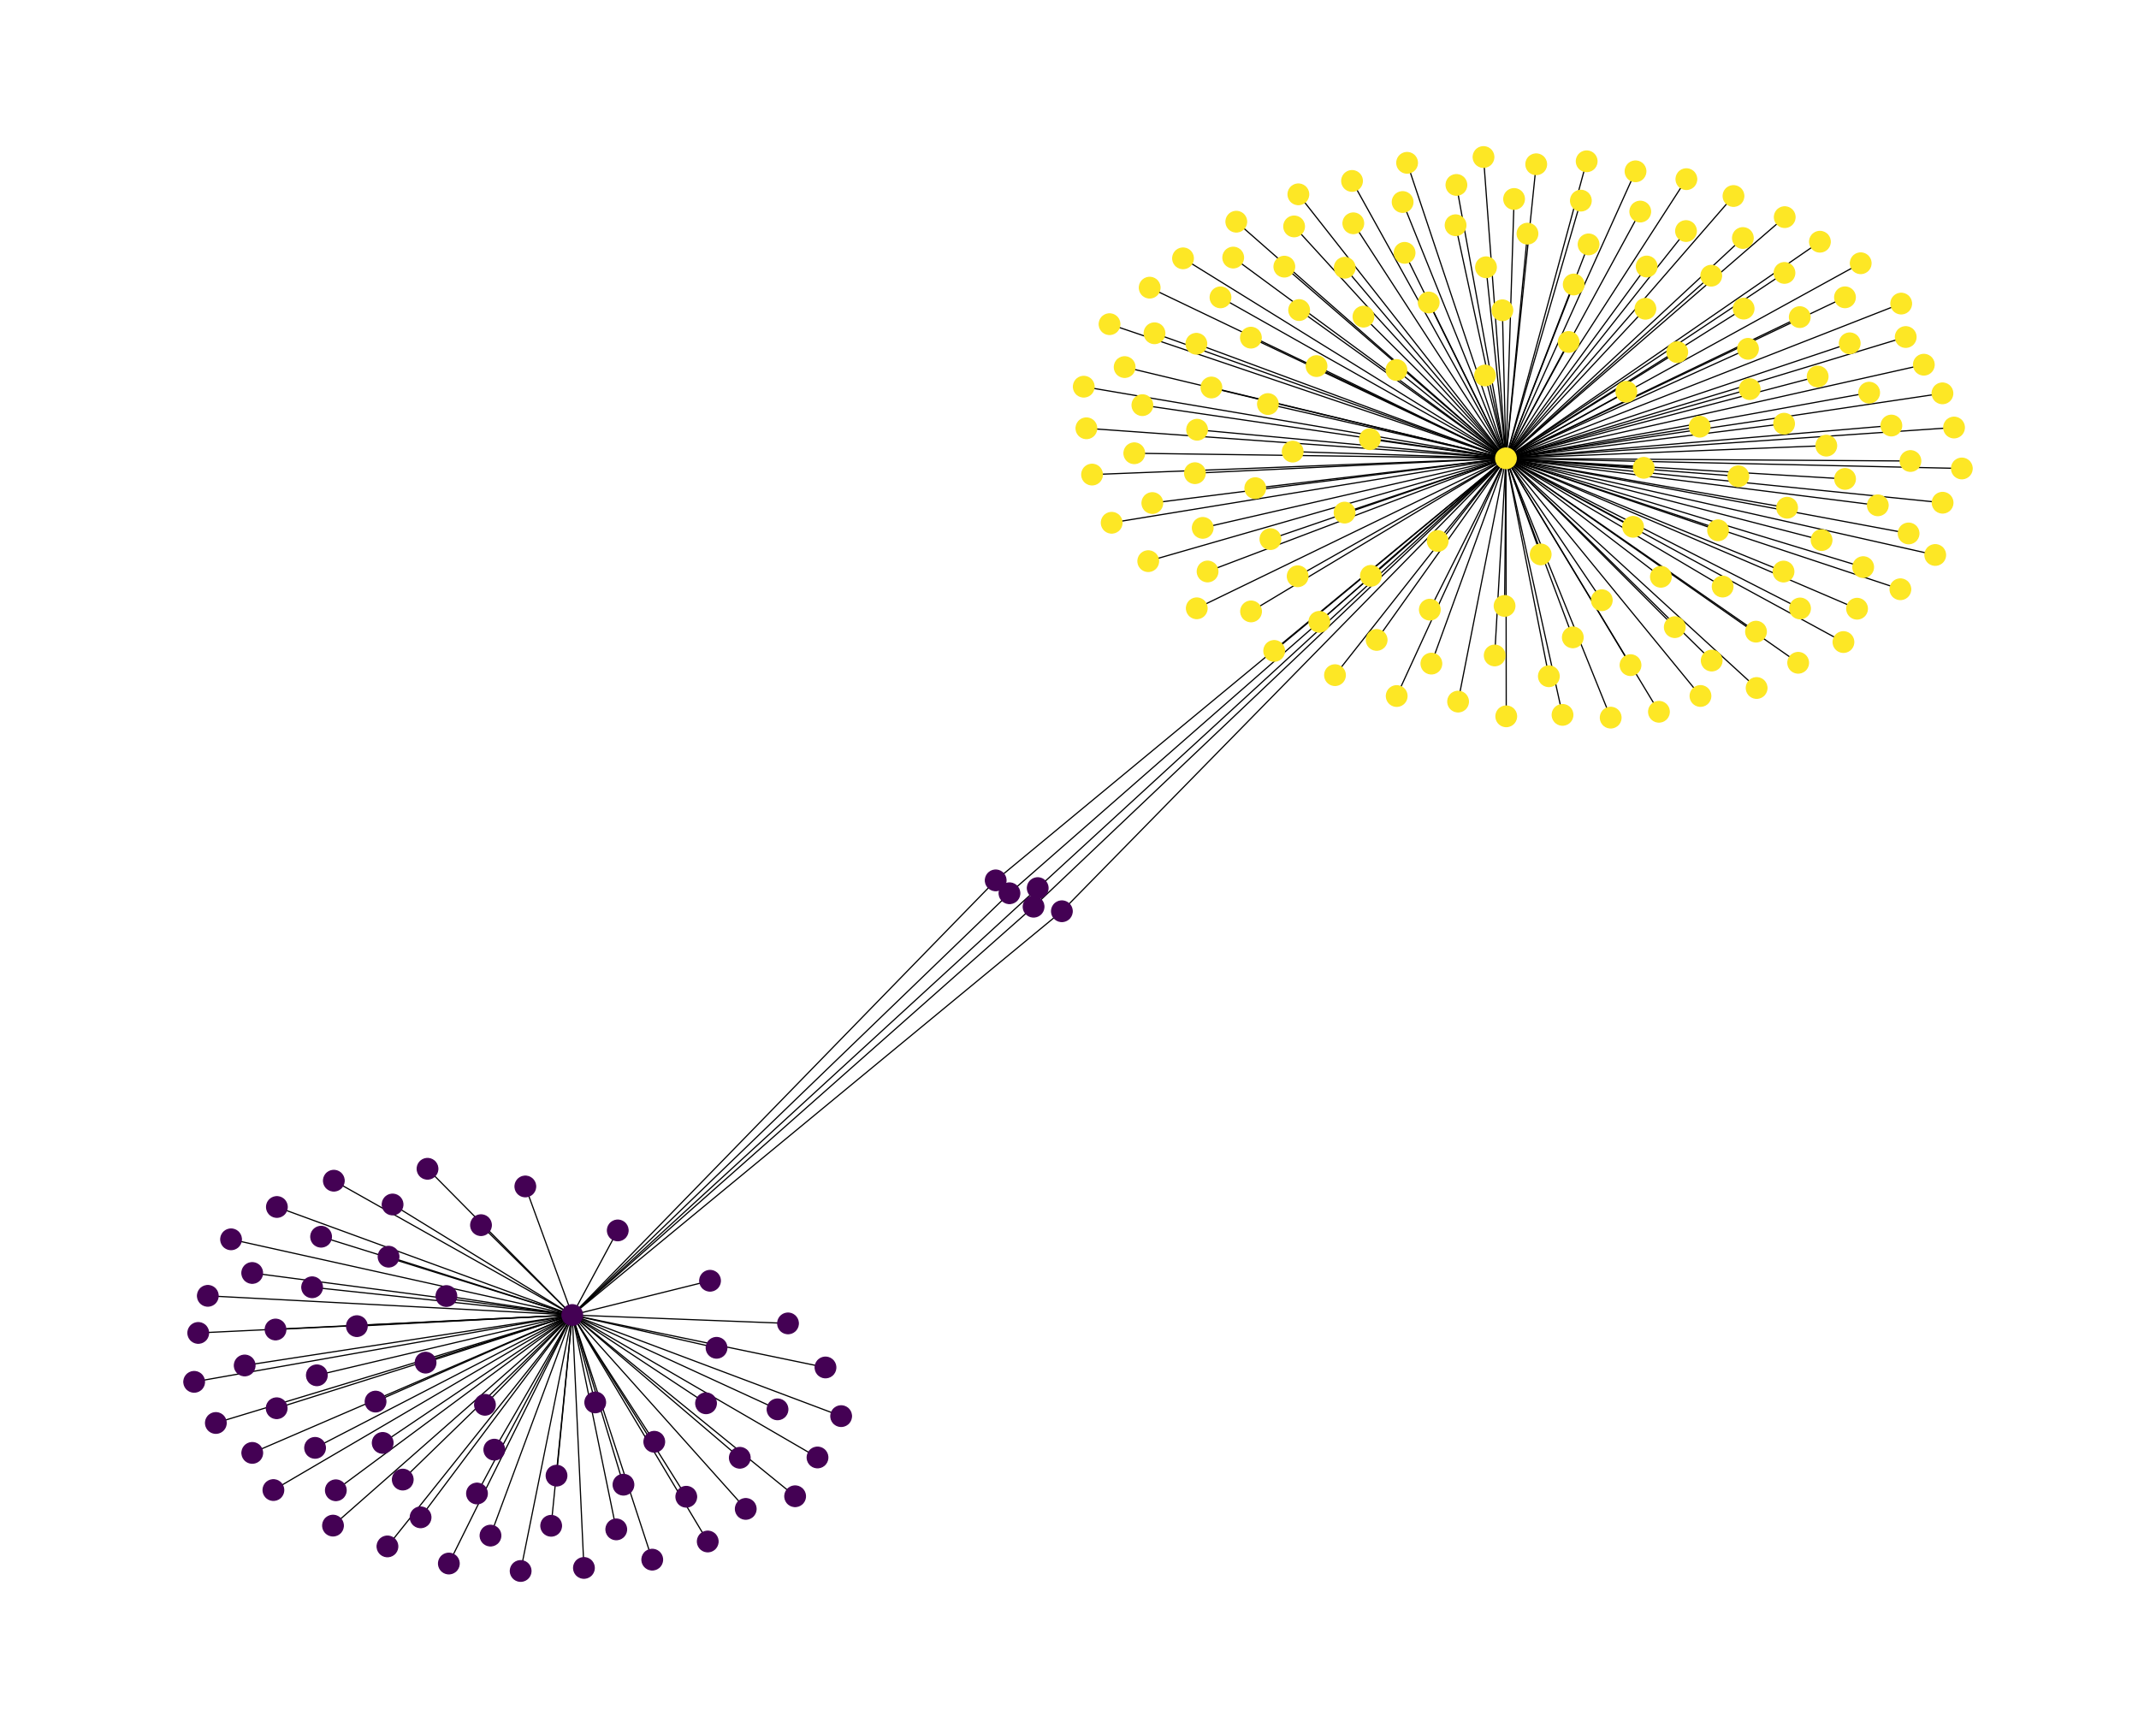

In [18]:
G = nx.Graph()
G = nx.from_pandas_edgelist(df, 'user.id','o365.audit.IsManagedDevice')

part = community.community_louvain.best_partition(G)
values = [part.get(node) for node in G.nodes()]

figure(figsize=(25, 20))
nx.draw_spring(G, node_color=values,with_labels=False)

## O365 - Inbox Rule Manipulation (T1114.003 Email Collection: Email Forwarding Rule)

In [ ]:
# Load the data
df = pd.read_csv('Logs.csv')

# Define the query conditions
query_condition_1 = (
     df['o365.audit.OperationProperties.Value'].str.contains('Forward') &
    (df['o365.audit.Operation'].str.contains('AddMailboxRule') |
     df['o365.audit.Operation'].str.contains('ModifyMailboxRule')) |
    (df['o365.audit.Operation'] == 'New-InboxRule')
)

query_condition_2 = (
    (df['event.action'] == 'Set-Mailbox') &
    (df['o365.audit.Parameters.ForwardingSmtpAddress'].str.len() > 0) |
    (df['o365.audit.Parameters.ForwardingAddress'].str.len() > 0)
)

# Apply the query conditions and filter the DataFrame
filtered_logs = df[query_condition_1 | query_condition_2]

# Aggregate stats
stats = filtered_logs.groupby(['sourceIPAddress', 'userIdentity.accountId', 'userAgent', 'userIdentity.principalId']).agg(
    count=pd.NamedAgg(column='eventTime', aggfunc='count'),
    firstTime=pd.NamedAgg(column='eventTime', aggfunc='min'),
    lastTime=pd.NamedAgg(column='eventTime', aggfunc='max')
).reset_index()

stats


## Azure AD - Federated Service Manipulation (T1484.002 Domain or Tenant Policy Modification: Trust Modification)

In [ ]:
# Load the data
df = pd.read_csv('Logs.csv')

# Filter the DataFrame based on required condition
filtered_df = df[
    (df['category'] == 'AuditLogs') &
    (df['properties.activityDisplayName'] == 'Set domain authentication') &
    (df['properties.result'] == 'success')
]

# Aggregate stats
stats = filtered_df.groupby(['sourceIPAddress', 'userIdentity.accountId', 'userAgent', 'userIdentity.principalId']).agg(
    count=pd.NamedAgg(column='eventTime', aggfunc='count'),
    firstTime=pd.NamedAgg(column='eventTime', aggfunc='min'),
    lastTime=pd.NamedAgg(column='eventTime', aggfunc='max')
).reset_index()

stats

## O365 Phish/Malware Detection (T1566: Phishing)

In [66]:
import pandas as pd

# Load the data
df = pd.read_csv('TIMailData.csv')


# Filter the DataFrame based on the condition
filtered_df = df[
    (df['input.type'] == 'o365audit') &
    (((df['event.action'] == 'TIMailData') & (df['o365.audit.Verdict'] == 'Phish')) | (df['event.action'] == 'TIUrlClickData')) &
    (df['event.outcome'] == 'success') &
    (df['o365.audit.DeliveryAction'] != 'Blocked')
]

# Aggregate stats
stats = filtered_df.groupby(['o365.audit.SenderIp', 'o365.audit.Subject']).agg(
    count=pd.NamedAgg(column='timestamp', aggfunc='count'),
    firstTime=pd.NamedAgg(column='timestamp', aggfunc='min'),
    lastTime=pd.NamedAgg(column='timestamp', aggfunc='max')
).reset_index()

# Stats
#stats[['o365.audit.DeliveryAction', 'o365.audit.DetectionMethod', 'o365.audit.Directionality', 'o365.audit.EventDeepLink', 'o365.audit.Subject', 'o365.audit.Verdict', 'o365.audit.AttachmentData']]
stats

,o365.audit.SenderIp,o365.audit.Subject,count,firstTime,lastTime
0,104.160.64.142,Here is the 2024 Green Home Builder Eco-Source...,270,2024-05-17T12:09:14.000Z,2024-05-17T12:09:14.000Z
1,104.160.64.142,The 2024 Builder & Developer BUYER'S GUIDE is ...,506,2024-05-17T13:08:25.000Z,2024-05-17T13:08:25.000Z
2,107.191.57.42,💊 Canadian Pharmacy Discounter 💊,363,2024-05-17T16:55:29.000Z,2024-05-17T16:55:29.000Z
3,116.197.157.8,David Luna Executive Profile for your review,14,2024-05-17T23:33:32.000Z,2024-05-17T23:33:32.000Z
4,13.110.246.200,Vendor Enrollment,285,2024-05-17T11:11:28.000Z,2024-05-17T11:11:28.000Z
...,...,...,...,...,...
94,92.167.192.54,June Is Employee Well-Being Month...Are You Re...,208,2024-05-17T15:35:02.000Z,2024-05-17T15:35:02.000Z
95,92.167.192.7,June Is Employee Well-Being Month...Are You Re...,208,2024-05-17T15:34:15.000Z,2024-05-17T15:34:15.000Z
96,92.167.192.79,June Is Employee Well-Being Month...Are You Re...,208,2024-05-17T15:35:04.000Z,2024-05-17T15:35:04.000Z
97,92.167.192.9,Unlock IT Resume Success with Pro Tips!,235,2024-05-17T14:17:21.000Z,2024-05-17T14:17:21.000Z


In [67]:
filtered_df[['o365.audit.DeliveryAction', 'o365.audit.DetectionMethod', 'o365.audit.Directionality', 'o365.audit.EventDeepLink', 'o365.audit.Subject', 'o365.audit.Verdict', 'o365.audit.AttachmentData']]

,o365.audit.DeliveryAction,o365.audit.DetectionMethod,o365.audit.Directionality,o365.audit.EventDeepLink,o365.audit.Subject,o365.audit.Verdict,o365.audit.AttachmentData
83,DeliveredAsSpam,Spoof external domain,Inbound,https://security.microsoft.com/?hash=/threatex...,The most evil political plot in U.S. history,Phish,NaN
84,DeliveredAsSpam,Spoof external domain,Inbound,https://security.microsoft.com/?hash=/threatex...,Elon Musk’s 2024 election warning,Phish,NaN
85,DeliveredAsSpam,Spoof external domain,Inbound,https://security.microsoft.com/?hash=/threatex...,The most evil political plot in U.S. history,Phish,NaN
86,DeliveredAsSpam,Spoof external domain,Inbound,https://security.microsoft.com/?hash=/threatex...,Elon Musk’s 2024 election warning,Phish,NaN
87,DeliveredAsSpam,Spoof external domain,Inbound,https://security.microsoft.com/?hash=/threatex...,Elon Musk’s 2024 election warning,Phish,NaN
...,...,...,...,...,...,...,...
96570,Delivered,Spoof external domain,Inbound,https://security.microsoft.com/?hash=/threatex...,36Piece Tupperware Modular Set Giveaway: Share...,Phish,NaN
96571,DeliveredAsSpam,Spoof external domain,Inbound,https://security.microsoft.com/?hash=/threatex...,Hello. My Friend. Funds Investment. Reply.,Phish,NaN
96578,DeliveredAsSpam,Spoof external domain,Inbound,https://security.microsoft.com/?hash=/threatex...,DERNIER rappel,Phish,NaN
96580,DeliveredAsSpam,Spoof external domain,Inbound,https://security.microsoft.com/?hash=/threatex...,DERNIER rappel,Phish,NaN


## Azure AD Risky Sign-Ons

In [ ]:
import pandas as pd

df = pd.read_json('Logs.csv')

filtered_df = df[
    (df['operationName'] == "Sign-in activity") &
    (df['properties'].apply(lambda x: 'riskState' in x and x['riskState'].lower() != "none")) &
    (df['properties'].apply(lambda x: 'userPrincipalName' in x and 'ipAddress' in x)) &
    (df['properties'].apply(lambda x: 'appDisplayName' in x and x.get('appDisplayName', '').lower() == 'officehome' and 'deviceDetail' in x and 'displayName' not in x['deviceDetail']))
]

okta_df = pd.read_json('OktaLogs.csv')

# Correlate with OKTA logs
correlated_df = filtered_df.merge(okta_df, how='inner', left_on='properties.userPrincipalName', right_on='actor.alternateId')

# Check if MFA passed
correlated_df['MFA_passed'] = correlated_df['outcome.result'] == 'success'

# Aggregate stats
stats = correlated_df.groupby(['properties.userPrincipalName']).agg(
    count=pd.NamedAgg(column='eventTime', aggfunc='count'),
    MFA_passed_count=pd.NamedAgg(column='MFA_passed', aggfunc='sum'),
    MFA_failed_count=pd.NamedAgg(column='MFA_passed', aggfunc=lambda x: len(x) - sum(x)),
    firstTime=pd.NamedAgg(column='eventTime', aggfunc='min'),
    lastTime=pd.NamedAgg(column='eventTime', aggfunc='max')
).reset_index()

stats


## IDEAS


**Suspicious OAuth App Permissions Changes**

   ```python
df[df['Operation'].isin(['AddOAuthPermission', 'RemoveOAuthPermission'])].groupby(['Application', 'User']).size()
   ```

**Suspicious Mailbox Folder Access**

   ```python
df[df['Activity'].isin(['FolderAccess', 'CreateFolder', 'DeleteFolder'])].groupby('User').size()
   ```

**Suspucious Access Denied Events**

   ```python
df[df['Activity'] == 'AccessDenied'].groupby('User').size()
   ```


**Massive Distribution List Changes**

   ```python
df[df['Activity'] == 'ModifyDistributionList']].groupby('User').size()
   ```
